In [1]:
%matplotlib inline
from hurricane_gis import load_best_track
from matplotlib import style

style.use(['dark_background', 'seaborn-poster'])

- searching for data endpoints with `pycsw`;
- static maps (`cartopy`);
- static plots (`matplotlib`).

In [2]:
radii, pts = load_best_track(code='al14', year='2018')

bbox = radii['geometry'].total_bounds
min_lon, max_lon = bbox[0], bbox[2]
min_lat, max_lat = bbox[1], bbox[3]

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

start = radii.index[0]
stop = radii.index[-1]

cf_names = ['sea_water_temperature',
            'sea_surface_temperature',
            'sea_water_potential_temperature',
            'equivalent_potential_temperature',
            'sea_water_conservative_temperature',
            'pseudo_equivalent_potential_temperature']

In [3]:
def fes_date_filter(start, stop, constraint='overlaps'):
    from owslib import fes
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')
    if constraint == 'overlaps':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                                literal=stop)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                 literal=start)
    elif constraint == 'within':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                   literal=start)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                              literal=stop)
    else:
        raise NameError(f'Unrecognized constraint {constraint}')
    return begin, end

In [4]:
from owslib import fes

kw = dict(wildCard='*',
          escapeChar='\\',
          singleChar='?',
          propertyname='apiso:AnyText')

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
     for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And([
        bbox_crs,
        begin, end, or_filt,
        fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)])]
    )]

In [5]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [6]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print(f'Found {len(csw.records.keys())} records.\n')

Found 401 records.



In [7]:
for key, value in list(csw.records.items()):
    print(f'[{value.title}]\n{key}\n')
    if '8728690' in key:
        break

[Zeke's Basin]
nerrs_noczbwq

[* 2nd Avenue Pier]
edu_ccu_lbos_2nd_ave_pier

[41002 SOUTH HATTERAS - 225 NM South of Cape Hatteras]
wmo_41002

[41004 EDISTO - 41 NM Southeast of Charleston, SC]
wmo_41004

[41008 GRAYS REEF - 40 NM Southeast of Savannah, GA]
university_of_georgia_uga_41008

[41009 CANAVERAL 20 NM East of Cape Canaveral, FL]
wmo_41009

[41010 CANAVERAL EAST - 120NM East of Cape Canaveral]
wmo_41010

[41013 Frying Pan Shoals, NC Buoy]
wmo_41013

[* 41024 / SUN2 Sunset Nearshore]
org_cormp_sun2

[41024 / SUN2 Sunset Nearshore - sea_water_temperature]
org.cormp:sun2:sea_water_temperature

[41024 / SUN2 Sunset Nearshore - sea_water_temperature-wave_site]
org.cormp:sun2:sea_water_temperature-wave_site

[41025 Diamond Shoals]
wmo_41025

[* 41029 / CAP2 Capers Nearshore]
org_cormp_cap2

[41029 / CAP2 Capers Nearshore - sea_water_temperature]
org.cormp:cap2:sea_water_temperature

[* 41033 / FRP2 Fripp Nearshore]
org_cormp_frp2

[41033 / FRP2 Fripp Nearshore - sea_water_temperatu

In [8]:
value.abstract

"Timeseries data from 'Apalachicola, FL' (urn:ioos:station:NOAA.NOS.CO-OPS:8728690)"

In [9]:
print('\n'.join(value.subjects))

earth science
atmosphere
ocean
biosphere
biology
environment
NOAA Center for Operational Oceanographic Products and Services CO-OPS
time
latitude
longitude
wind_speed
air_pressure
sea_surface_height_above_sea_level
wind_from_direction
sea_water_temperature
wind_speed_of_gust
air_temperature
sea_surface_height_amplitude_due_to_geocentric_ocean_tide
depth
geoscientificInformation


In [10]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: WWW:LINK
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/noaa_nos_co_ops_8728690.html

geolink: None
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/noaa_nos_co_ops_8728690.graph

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/noaa_nos_co_ops_8728690

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/noaa_nos_co_ops_8728690



In [11]:
url = ref['url'] + (
    '.csvp?sea_surface_height_above_sea_level_geoid_MLLW,sea_water_temperature,time'
    f'&time>={start:%Y-%m-%dT00:00:00}'
    f'&time<={stop:%Y-%m-%dT00:00:00}'
)

print(url)

http://erddap.secoora.org/erddap/tabledap/noaa_nos_co_ops_8728690.csvp?sea_surface_height_above_sea_level_geoid_MLLW,sea_water_temperature,time&time>=2018-10-07T00:00:00&time<=2018-10-12T00:00:00


In [12]:
from erddapy.utilities import urlopen
import pandas as pd

df = pd.read_csv(
    urlopen(url),
    index_col='time (UTC)',
    parse_dates=True,
)

df.dropna(inplace=True)
df.head()

,sea_surface_height_above_sea_level_geoid_MLLW (ft),sea_water_temperature (degree_Fahrenheit)
time (UTC),,
2018-10-12 00:00:00,2.4311,80.24
2018-10-11 23:54:00,2.4475,80.24
2018-10-11 23:48:00,2.4639,80.24
2018-10-11 23:42:00,2.4770,80.24
2018-10-11 23:36:00,2.4869,80.24


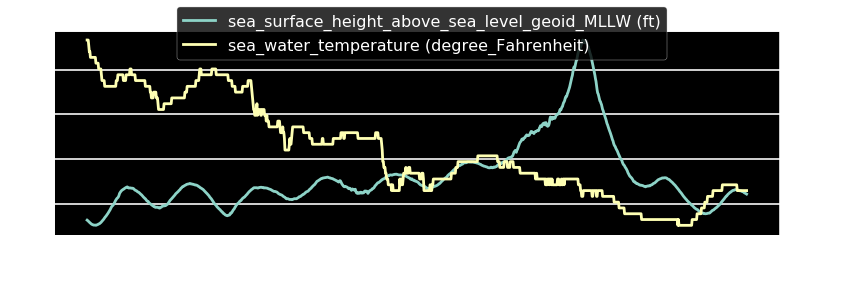

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13, 3.75))
ax = df['sea_surface_height_above_sea_level_geoid_MLLW (ft)'].plot(
    ax=ax, legend=False)

df['sea_water_temperature (degree_Fahrenheit)'].plot(
    secondary_y=True, legend=False)

ax.set_xlabel('')
ax.right_ax.set_ylabel('degree_Fahrenheit')
ax.set_ylabel('MLLW (ft)')
ax.grid(True)
fig.legend(loc='upper center');